LBP+Random forest

Extracting LBP features...


E:\Anaconda\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
E:\Anaconda\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


              precision    recall  f1-score   support

 Agriculture       0.51      0.49      0.50       171
     Airport       0.39      0.46      0.42       158
       Beach       0.60      0.51      0.55       169
        City       0.57      0.54      0.56       166
      Desert       0.62      0.49      0.54       158
      Forest       0.73      0.88      0.80       143
   Grassland       0.73      0.72      0.73       167
     Highway       0.58      0.56      0.57       158
        Lake       0.56      0.46      0.51       154
    Mountain       0.60      0.73      0.66       162
     Parking       0.65      0.69      0.67       171
        Port       0.68      0.64      0.66       155
     Railway       0.62      0.61      0.62       164
 Residential       0.60      0.77      0.67       148
       River       0.32      0.26      0.29       156

    accuracy                           0.59      2400
   macro avg       0.58      0.59      0.58      2400
weighted avg       0.58   

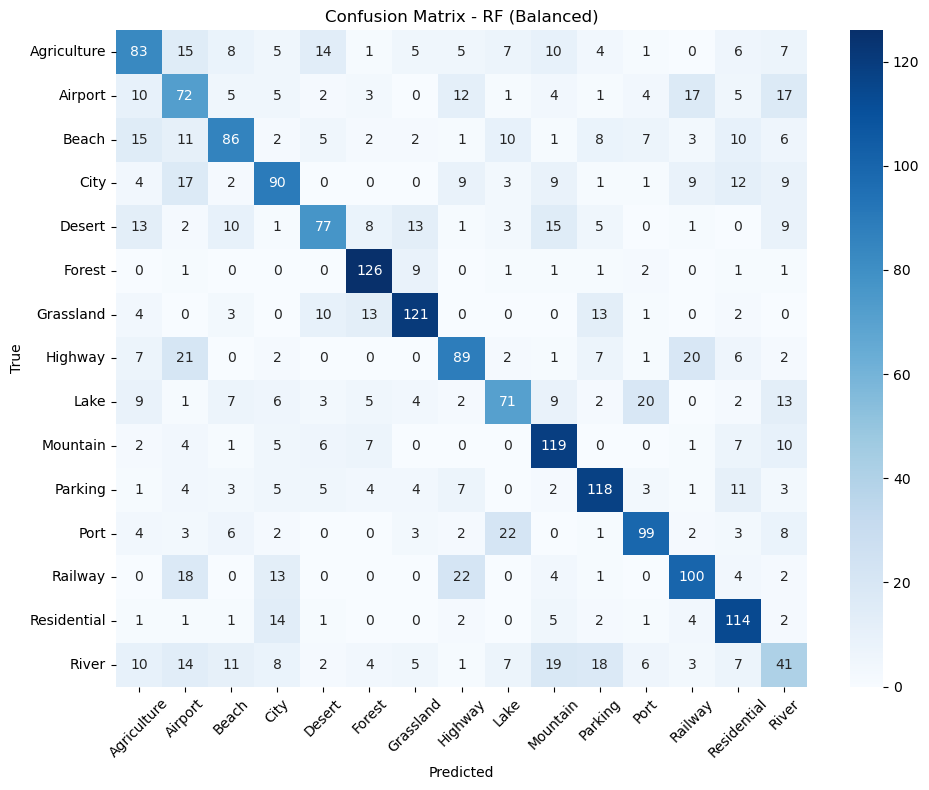

              precision    recall  f1-score   support

 Agriculture       0.38      0.61      0.47       171
     Airport       0.29      0.67      0.40       158
       Beach       0.48      0.55      0.52       169
        City       0.36      0.62      0.46       166
      Desert       0.57      0.53      0.55       158
      Forest       0.70      0.89      0.78       143
   Grassland       0.70      0.70      0.70       167
     Highway       0.51      0.56      0.53       158
        Lake       0.57      0.45      0.50       154
    Mountain       0.63      0.67      0.65       162
     Parking       0.67      0.56      0.61       171
        Port       0.80      0.43      0.55       155
     Railway       0.75      0.18      0.29       164
 Residential       0.75      0.22      0.34       148
       River       0.00      0.00      0.00       156

    accuracy                           0.51      2400
   macro avg       0.54      0.51      0.49      2400
weighted avg       0.54   

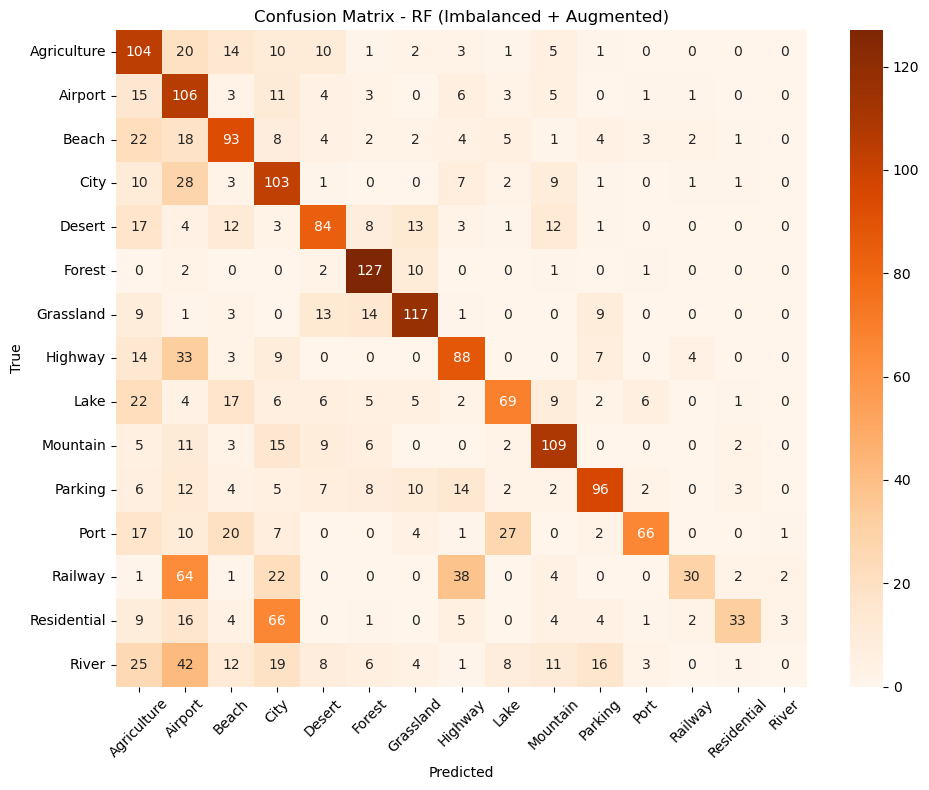

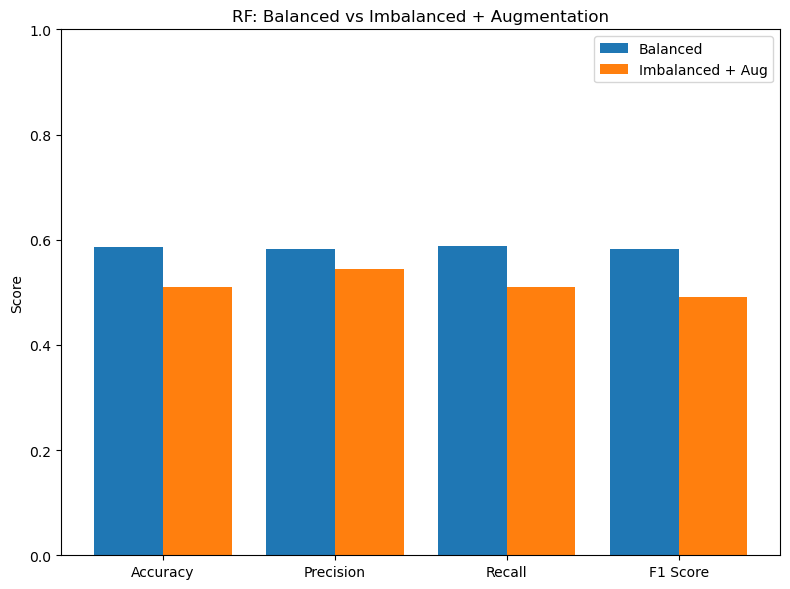

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.filters import median
from skimage.morphology import disk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# ===================== Parameters =====================
IMG_SIZE = (256, 256)
RADIUS = 2
N_POINTS = 16 * RADIUS
METHOD = 'uniform'
DISK_SIZE = 3

DATASET_DIR = r'D:/quark download/9517 Week1 home work/project/Aerial_Landscapes'
INDEX_DIR = r'D:/quark download/9517 Week1 home work/project/preprocess'
TRAIN_IDX_PATH = os.path.join(INDEX_DIR, 'train_indices.npy')
VAL_IDX_PATH = os.path.join(INDEX_DIR, 'val_indices.npy')

RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = None
RANDOM_SEED = 42

# ===================== Helper Functions =====================
def load_all_images_and_labels(dataset_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    for cls in class_names:
        cls_dir = os.path.join(dataset_dir, cls)
        for fname in sorted(os.listdir(cls_dir)):
            if fname.lower().endswith('.jpg'):
                image_paths.append(os.path.join(cls_dir, fname))
                labels.append(class_to_idx[cls])
    return np.array(image_paths), np.array(labels), class_names

def load_images_by_indices(indices, image_paths, labels):
    X, y = [], []
    for i in indices:
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img / 255.0)
        y.append(labels[i])
    return np.array(X), np.array(y)

def compute_lbp_histogram(image):
    gray = rgb2gray(image)
    denoised = median(gray, disk(DISK_SIZE))
    lbp = local_binary_pattern(denoised, N_POINTS, RADIUS, METHOD)
    n_bins = int(N_POINTS + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    return hist.astype('float') / (hist.sum() + 1e-7)

def extract_lbp_features(images):
    return np.array([compute_lbp_histogram(img) for img in images])


def augment_image(image):
    augmented = []
    if random.random() < 0.5:
        augmented.append(np.fliplr(image))
    if random.random() < 0.5:
        augmented.append(np.flipud(image))
    if random.random() < 0.5:
        bright = np.clip(image + np.random.uniform(0.1, 0.3), 0, 1)
        augmented.append(bright)
    if random.random() < 0.5:
        contrast = np.clip(image * np.random.uniform(0.7, 1.3), 0, 1)
        augmented.append(contrast)
    if random.random() < 0.5:
        noise = image + np.random.normal(0, 0.03, image.shape)
        augmented.append(np.clip(noise, 0, 1))
    return augmented if augmented else [image]


def create_augmented_imbalanced_dataset(X, y, min_count=50):
    unique_classes = np.unique(y)
    original_count = np.sum(y == unique_classes[0])
    new_X, new_y = [], []
    for i, cls in enumerate(sorted(unique_classes)):
        desired = int(round(original_count - i * ((original_count - min_count) / (len(unique_classes) - 1))))
        indices = np.where(y == cls)[0]
        np.random.shuffle(indices)
        selected = indices[:desired]
        for idx in selected:
            new_X.append(X[idx])
            new_y.append(y[idx])
        if desired < 80:
            for idx in selected:
                aug_imgs = augment_image(X[idx])
                for aug in aug_imgs:
                    new_X.append(aug)
                    new_y.append(y[idx])
    return extract_lbp_features(np.array(new_X)), np.array(new_y)

def evaluate_and_plot(y_true, y_pred, title, labels, cmap):
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ===================== Main Flow =====================
image_paths, labels, class_names = load_all_images_and_labels(DATASET_DIR)
train_indices = np.load(TRAIN_IDX_PATH)
val_indices = np.load(VAL_IDX_PATH)

X_train_raw, y_train = load_images_by_indices(train_indices, image_paths, labels)
X_test_raw, y_test = load_images_by_indices(val_indices, image_paths, labels)

print("Extracting LBP features...")
X_train_feats = extract_lbp_features(X_train_raw)
X_test_feats = extract_lbp_features(X_test_raw)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_feats)
X_test_norm = scaler.transform(X_test_feats)

# Balanced RF training
rf_bal = RandomForestClassifier(n_estimators=RF_N_ESTIMATORS, max_depth=RF_MAX_DEPTH, random_state=RANDOM_SEED)
rf_bal.fit(X_train_norm, y_train)
y_pred_bal = rf_bal.predict(X_test_norm)

X_imbal, y_imbal = create_augmented_imbalanced_dataset(X_train_raw, y_train)
X_imbal = scaler.transform(X_imbal)
rf_imbal = RandomForestClassifier(n_estimators=RF_N_ESTIMATORS, max_depth=RF_MAX_DEPTH,
                                  class_weight='balanced',
                                  random_state=RANDOM_SEED)
rf_imbal.fit(X_imbal, y_imbal)
y_pred_imbal = rf_imbal.predict(X_test_norm)

# Evaluation
evaluate_and_plot(y_test, y_pred_bal, "Confusion Matrix - RF (Balanced)", class_names, cmap="Blues")
evaluate_and_plot(y_test, y_pred_imbal, "Confusion Matrix - RF (Imbalanced + Augmented)", class_names, cmap="Oranges")

# Metric Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bal_scores = [accuracy_score(y_test, y_pred_bal),
              precision_score(y_test, y_pred_bal, average='macro'),
              recall_score(y_test, y_pred_bal, average='macro'),
              f1_score(y_test, y_pred_bal, average='macro')]
imbal_scores = [accuracy_score(y_test, y_pred_imbal),
                precision_score(y_test, y_pred_imbal, average='macro'),
                recall_score(y_test, y_pred_imbal, average='macro'),
                f1_score(y_test, y_pred_imbal, average='macro')]

plt.figure(figsize=(8, 6))
x = np.arange(len(metrics))
plt.bar(x - 0.2, bal_scores, 0.4, label='Balanced')
plt.bar(x + 0.2, imbal_scores, 0.4, label='Imbalanced + Aug')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('RF: Balanced vs Imbalanced + Augmentation')
plt.legend()
plt.tight_layout()
plt.show()